# PEC 0

# Setup

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
TF_USE_LEGACY_KERAS=True

Vamos a crear la carpeta `images/ann` (si no existe ya), y definir la función `save_fig()` que se utiliza a través de este cuaderno para guardar las figuras en alta resolución para el libro:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ann"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Definimos la siguiente funcion para despues de cada entrenado de un modelo, limpiamos los restos....

In [3]:
def clean_session():
    tf.keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)

Nos definimos una funcion auxiliar para ver la tasa de aprendizaje en cada punto.

In [4]:
def view_learning_rate(expon_lr_default):
    plt.figure(figsize=(5, 3))
    plt.plot(expon_lr_default.rates, expon_lr_default.losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(expon_lr_default.losses), min(expon_lr_default.rates), max(expon_lr_default.rates))
    plt.axis([min(expon_lr_default.rates), max(expon_lr_default.rates), 0, expon_lr_default.losses[0]])
    plt.grid()
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

    min_value = min(expon_lr_default.losses)
    print("El factor de perdida mas pequeno:", min(expon_lr_default.losses))
    index = expon_lr_default.losses.index(min_value)
    print("Factor de learning rate en el punto mas abajo:", expon_lr_default.rates[index])

# Inspeccion de los datos

Cargamos el dataset ya dividido en train y test.

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

Al igual que el conjunto de datos Fashion MNIST, el conjunto de entrenamiento MNIST contiene 60.000 imágenes en escala de grises, cada una de 28x28 píxeles:

In [6]:
X_train_full.shape

(60000, 28, 28)

La intensidad de cada píxel también se representa como un byte (de 0 a 255):

In [7]:
X_train_full.dtype

dtype('uint8')

Vamos a dividir el conjunto de entrenamiento completo en un conjunto de validación y un conjunto de entrenamiento (más pequeño). También reducimos las intensidades de los píxeles al rango 0-1 y las convertimos en flotantes, dividiéndolas por 255, igual que hicimos para Fashion MNIST:

In [8]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Vamos a mostrar una imagen de nuestro dataset, concretamente la imagen en la posicion 6 de la variable X_train_full

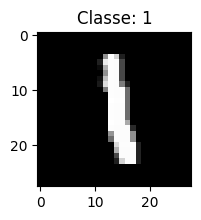

In [9]:
def show_example(id):
    plt.figure(figsize=(2, 2)) # Hacemos que la fotografia se vea mas pquena
    plt.imshow(X_train_full[id], cmap='gray')
    plt.title(f"Classe: {y_train_full[id]}")
    plt.show()

show_example(6)

Vamos a mostrar mas datos aleatorios de nuestro dataset de entrenamiento con su respectiva classe

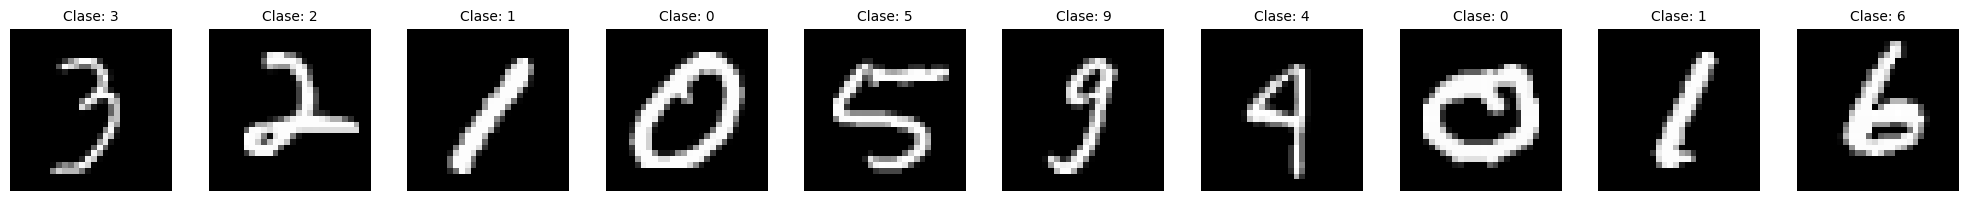

In [10]:
import random

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    # Pick random values from dataset
    random_value_from_dataset = random.randint(0, X_train_full.shape[0])
    ax = axes[i]
    ax.imshow(X_train_full[random_value_from_dataset], cmap='gray', interpolation='nearest')
    ax.set_title(f"Clase: {y_train_full[random_value_from_dataset]}", fontsize=10)
    ax.axis('off')  # Ocultar los ejes
plt.tight_layout()
plt.show()

En algunos datasets, la clase objetivo a predecir puede ser una categoría como "perro", "gato", etc. En estos casos, asignamos un valor numérico (INT) a cada clase para facilitar su procesamiento. Por ejemplo, mapeamos "perro" como clase 1 y "gato" como clase 2, lo cual permite que el modelo interprete las categorías de manera más eficiente.

Pero en este caso, podemos ver que nuestro y_train ya viene representado con esas clases que corresponden a los mismos numeros.

In [11]:
y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [12]:
X_valid.shape

(5000, 28, 28)

In [13]:
X_test.shape

(10000, 28, 28)

Vamos a construir una red densa simple y encontrar la tasa de aprendizaje óptima. Necesitaremos una llamada de retorno para aumentar la tasa de aprendizaje en cada iteración. También registrará la tasa de aprendizaje y la pérdida en cada iteración:

# Ejercicio del Libro

A continuación, definiremos una clase de soporte llamada ExponentialLearningRate, que nos ayudará a ajustar dinámicamente la tasa de aprendizaje durante el entrenamiento.

La idea principal es aumentar la tasa de aprendizaje después de cada batch de entrenamiento, aplicando un incremento gradual.

Al usar este callback, la tasa de aprendizaje se incrementará progresivamente con cada batch, lo cual es especialmente útil en las etapas iniciales del entrenamiento para acelerar el aprendizaje del modelo.

In [14]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_batch_end(self, batch, logs=None):
        lr = self.model.optimizer.learning_rate.numpy() * self.factor
        self.model.optimizer.learning_rate = lr
        self.rates.append(lr)
        self.losses.append(logs["loss"])

In [15]:
clean_session()

Definimos nuestro primer modelo con dos capas ocultas.
- La primera capa cuenta con 300 neuronas
- Mientras que la segunda tiene 100 neuronas.

In [16]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Empezaremos con un learning rate pequeno de 1e-3, y lo iremos incrementando un 0.5% en cada iteracion gracias a la clase que hemos hecho anteriormente ExponentialLearningRate.

In [17]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

Ahora entrenaremos nuestro modelo por solo una ephoc.

In [18]:
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 23s 12ms/step - accuracy: 0.5108 - loss: nan - val_accuracy: 0.0958 - val_loss: nan


A continuación, observamos el desempeño de nuestro modelo después de una única época de entrenamiento.

El factor de perdida mas pequeno: 1.0179802179336548
Factor de learning rate en el punto mas abajo: 0.7413650035858154


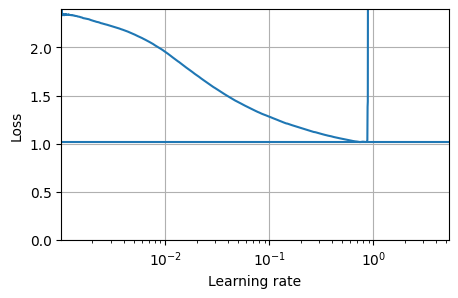

In [19]:
view_learning_rate(expon_lr)


Observamos que en las coordenadas Loss = 1.009 y Learning rate = 0.8 se produce un incremento abrupto. Esto ocurre porque, en ese punto, el algoritmo deja de aprender: probablemente el paso es demasiado grande y está superando el mínimo óptimo.

Para corregir esto, reduciremos el factor de la tasa de aprendizaje a la mitad, quedando en 0.4 (equivalente a 4e-1).

In [20]:
clean_session()

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
#optimizer = tf.keras.optimizers.SGD(learning_rate=3e-1)
optimizer = tf.keras.optimizers.SGD(learning_rate=4e-1)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
run_index = 1
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)
run_logdir

PosixPath('my_mnist_logs/run_001')

In [22]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.8660 - loss: 0.4223 - val_accuracy: 0.9680 - val_loss: 0.1039


In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,612 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [24]:
model = tf.keras.models.load_model("my_mnist_model.keras") # rollback to best model
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9643 - loss: 0.1144


[0.10132152587175369, 0.9686999917030334]

Podemos ver que hemos llegado a un 97 porciento de accuracy

# Red con 3 capas oculta

In [25]:
clean_session()

En este modelo crearemos 3 capas oculatas:

*   La primera contiene 300 neuronas.
*   La segunda contiene 200 neuronas.
*   La tercera contiene 100 neuronas.



1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.4764 - loss: nan - val_accuracy: 0.0958 - val_loss: nan
El factor de perdida mas pequeno: 1.1044999361038208
Factor de learning rate en el punto mas abajo: 0.8191308867931365


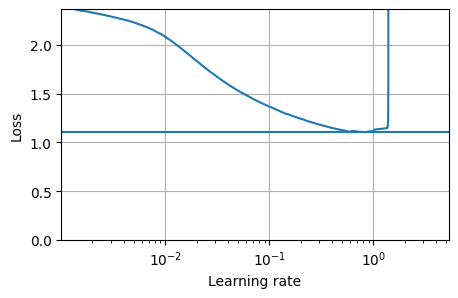

In [26]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer_3 = tf.keras.optimizers.SGD(learning_rate=1e-3)
model_3.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer_3,
              metrics=["accuracy"])
expon_lr_3 = ExponentialLearningRate(factor=1.005)
history = model_3.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr_3])
view_learning_rate(expon_lr_3)

Tras ejecutar en un par de ocasiones y ver el factor de learning rate que nos interesa, podemos concluir que nos sale una media de 0.8. Entonces, dividiremos por 2 este factor para encontrar mejores soluciones.

In [27]:
clean_session()

In [28]:
model_3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer_3 = tf.keras.optimizers.SGD(learning_rate=4e-1)
model_3.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_3,
              metrics=["accuracy"])
run_index = 2
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model_3.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model_3.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.8100 - loss: 0.5996 - val_accuracy: 0.9604 - val_loss: 0.1354


In [29]:
model_3 = tf.keras.models.load_model("my_mnist_model_3.keras")
model_3.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9560 - loss: 0.1479


[0.1325315684080124, 0.9599999785423279]

# Red con 4 capas ocultas

In [30]:
clean_session()

En este modelo crearemos 4 capas oculatas:

- La primera contiene 400 neuronas.
- La segunda contiene 300 neuronas.
- La tercera contiene 200 neuronas.
- La cuarta contiene 100 neuronas.

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.4240 - loss: nan - val_accuracy: 0.0958 - val_loss: nan
El factor de perdida mas pequeno: 1.2070876359939575
Factor de learning rate en el punto mas abajo: 0.5100084999203681


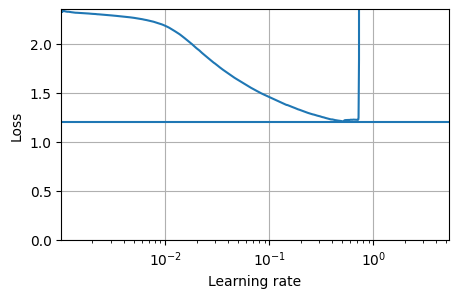

In [31]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(400, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer_4 = tf.keras.optimizers.SGD(learning_rate=1e-3)
model_4.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer_4,
              metrics=["accuracy"])
expon_lr_4 = ExponentialLearningRate(factor=1.005)
history = model_4.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr_4])
view_learning_rate(expon_lr_4)

In [32]:
clean_session()

In [33]:
model_4 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(400, activation="relu"),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(200, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer_4 = tf.keras.optimizers.SGD(learning_rate=3e-1)
model_4.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_4,
              metrics=["accuracy"])
run_index = 4
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model_4.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model_4.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7887 - loss: 0.6637 - val_accuracy: 0.9646 - val_loss: 0.1233


In [34]:
model_4 = tf.keras.models.load_model("my_mnist_model_4.keras") # rollback to best model
model_4.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9586 - loss: 0.1434


[0.12070970237255096, 0.9646000266075134]

# Comparación de modelos

En este apartado, realizaremos una comparación detallada de los tres modelos que he desarrollado. Para asegurar una evaluación justa, cada modelo ha sido entrenado durante una sola época, aunque en condiciones estándar se emplearían múltiples épocas para optimizar el rendimiento.

Esta limitación nos permite realizar una comparación más equilibrada y directa entre los modelos en cuanto a su rendimiento inicial. Además, al restringir el entrenamiento a una única época, podemos analizar con mayor precisión las métricas del learning rate en cada modelo, obteniendo así una visión más clara de sus respectivos comportamientos y diferencias en el proceso de aprendizaje.


### **Modelo base**
En el primer modelo, observamos una arquitectura sencilla con solo dos capas ocultas: la primera con 300 neuronas y la segunda con 100 neuronas. Al ajustar el learning rate y realizar un entrenamiento de una sola época, el modelo logra resolver el problema de manera satisfactoria. Esto se debe a la baja complejidad de la red, que cuenta con pocos parámetros y, por lo tanto, facilita el ajuste. Los resultados en las pruebas demuestran un desempeño notable, evidenciando que este modelo es capaz de generalizar adecuadamente incluso con un entrenamiento mínimo.



In [35]:
model = tf.keras.models.load_model("my_mnist_model.keras") # rollback to best model
model.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9643 - loss: 0.1144


[0.10132152587175369, 0.9686999917030334]

In [36]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          30,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 266,612 (1.02 MB)

 Trainable params: 266,610 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### **Modelo con 3 capas ocultas**
En el modelo con tres capas ocultas encontramos que la primera capa oculta es de 300, la segunda de 200 y la tercera de 100. Podemos que tras ajustar el valor del learning rate, es capaz tambien de con solo una ephoca, generalizar correctamente.

Pero si comparamos con el modelo de solo 2 capas ocultas, podemos observar que hay un ligero cambio en lo que ocupa la red. Mientras que en el primera red encontramos **266,612 parametros**, mientras que en esta encontramos **316,812 parametros**  

In [37]:
model_3 = tf.keras.models.load_model("my_mnist_model_3.keras")
model_3.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9560 - loss: 0.1479


[0.1325315684080124, 0.9599999785423279]

In [38]:
model_3.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │         235,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │          60,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 316,812 (1.21 MB)

 Trainable params: 316,810 (1.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

En términos de rendimiento, ambos modelos muestran un comportamiento bastante similar. Sin embargo, optaríamos lógicamente por el primer modelo, ya que tiene una cantidad menor de parámetros, lo que lo hace más eficiente.

### Modelo de 4 capas ocultas

Este modelo presenta una arquitectura más extensa, con una primera capa de 400 neuronas, seguida de una segunda con 300, una tercera con 200, y una cuarta capa de 100 neuronas. A simple vista, parece que este modelo es excesivamente grande; si logramos resolver el problema de manera óptima con menos capas y neuronas, ¿por qué añadir complejidad innecesaria?

Al compararlo, notamos que, con una sola época de entrenamiento, este modelo no alcanza el mismo nivel de precisión que los otros dos, mostrando un rendimiento menos eficiente. Esta disminución en el accuracy puede atribuirse al aumento significativo en los parámetros: a diferencia del modelo con tres capas ocultas, esta red tiene **515,612 parámetros**, lo que hace el proceso de ajuste más demandante y menos efectivo.

Realmente si hacemos un entrenamiento con mas ephocs, podriamos llegar al mismo valor del accuracy, pero hacer esto no tiene sentido.

In [39]:
model_4.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 400)                 │         314,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 300)                 │         120,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 200)                 │          60,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 515,612 (1.97 MB)

 Trainable params: 515,610 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### Que pasa si la red de 3 capas tiene mas neuronas?
Si lo que hemos dicho es cierto, si creasemos una red de 3 capas ocultas con muchos mas parametros, obtendriamos unos resultados similares a los de la red 4.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.5393 - loss: nan - val_accuracy: 0.0958 - val_loss: nan
El factor de perdida mas pequeno: 1.023756504058838
Factor de learning rate en el punto mas abajo: 0.8232265520095824


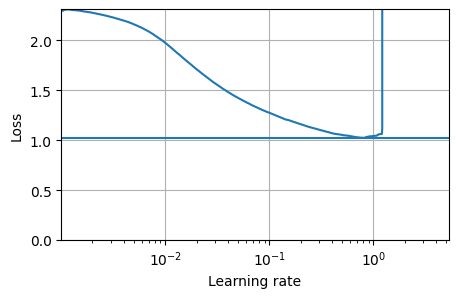

In [40]:
model_3_test = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(800, activation="relu"),
    tf.keras.layers.Dense(700, activation="relu"),
    tf.keras.layers.Dense(600, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer_3_test = tf.keras.optimizers.SGD(learning_rate=1e-3)
model_3_test.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer_3_test,
              metrics=["accuracy"])
expon_lr_3_test = ExponentialLearningRate(factor=1.005)
history = model_3_test.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr_3_test])
view_learning_rate(expon_lr_3_test)

In [41]:
model_3_test = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(800, activation="relu"),
    tf.keras.layers.Dense(700, activation="relu"),
    tf.keras.layers.Dense(600, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer_3_test = tf.keras.optimizers.SGD(learning_rate=1e-3)
model_3_test.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer_3_test,
              metrics=["accuracy"])
run_index = 5
run_logdir = Path() / "my_mnist_logs" / "run_{:03d}".format(run_index)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_mnist_model_5.keras", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)

history = model_3_test.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 31s 18ms/step - accuracy: 0.3882 - loss: 2.1000 - val_accuracy: 0.7938 - val_loss: 1.2529


In [42]:
model_3_test = tf.keras.models.load_model("my_mnist_model_5.keras")
model_3_test.evaluate(X_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7628 - loss: 1.3153


[1.2448982000350952, 0.7936999797821045]

Como hemos podido ver, el modelo ha empeorado bastante respecto a los demas modelos. Esto es logico ya que hemos aumentado los **parametros de entrenamiento en 1,615,312**.



In [43]:
model_3_test.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 800)                 │         628,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 700)                 │         560,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 600)                 │         420,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 10)                  │           6,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,615,312 (6.16 MB)

 Trainable params: 1,615,310 (6.16 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# Conclusion Final
En conclusión, si logramos desarrollar un modelo más pequeño que, gracias a un ajuste adecuado de la tasa de aprendizaje (learning rate), pueda aprender de manera lógica y estructurada, este modelo puede llegar a ofrecer un rendimiento superior en comparación con uno más grande y complejo.

La tasa de aprendizaje, bien calibrada, permite que el modelo pequeño optimice su capacidad de aprendizaje sin caer en problemas comunes de modelos más grandes, como el sobreajuste. Esto significa que, al evitar la inclusión innecesaria de capas adicionales y centrarse en una arquitectura simplificada, el modelo pequeño puede alcanzar una generalización más efectiva y consistente.

En última instancia, si este modelo más compacto logra captar patrones esenciales en los datos y adaptarse de forma correcta a nuevas situaciones, es probable que su desempeño sea incluso superior al de modelos más grandes que incluyen muchas capas, pero que pueden volverse menos eficientes o precisos al intentar aprender de datos más complejos.